In [1]:
from HARK.frame import (
    BackwardFrameReference,
    ForwardFrameReference,
    Frame,
    FrameAgentType,
    FrameModel,
    draw_frame_model,
)

from HARK.distribution import combine_indep_dstns, add_discrete_outcome_constant_mean
from HARK.distribution import (
    IndexDistribution,
    Lognormal,
    MeanOneLogNormal,
    Bernoulli,  # Random draws for simulating agents
)

from HARK.rewards import (
    CRRAutility,
)

TO DO:

Refactor to separate model from simulator (AgentType)

- [x] Separate FrameModel from FrameAgentType - AgentType has cycles parameter. FrameModel need not have it.
- [x] Define Repeater transformation -- transforms FrameModel to be either explicitly infinite or to become finite cycled. Can take age-varying parameters here (and only here).
- [x] FrameAgentType consumes a FrameModel, and runs simulations in HARK way
- [ ] Further decouple FrameModel from FrameAgentType.
  - [x] FrameModel should take parameters dictionary
  - [x] Generalize simulation to access appropriate solution (transition_cNrm)
  - [ ] FrameModel transition equations should not reference 'self' whiteboard
  - [ ] FrameAgentType with an arbitrary well-formed FrameModel and solution should be able to forward-simulate
  - [x] Replicate the ConsPortfolioFrameModel with new architecture.
- [ ] Automated tests
- [ ] Easier single variable target frames

Solver as something that consumes and works with a FrameModel

- [ ] Data structure for the solution of a model? -- A policy. (Look at Bellman library?)
- [ ] Extract the key sequence of variables along which to pass value
- [ ] Value-passing -- inverse function
- [ ] Value-passing -- Inverse expected value -- for chance transitions
- [ ] Policy updating --
- [ ] Value backup

Solvers for repeated FrameModels

- [ ] Finite solver as composition of these tools
- [ ] Infinite solver through use of tools to convergence

Feed solution back to FrameAgentType

- [ ] Build solution object a la HARK? Or ...
- [ ] Adjust simulator so that it uses the new solution object

## Some simple models

In [2]:
init_parameters = {}
init_parameters["PermGroFac"] = 1.05
init_parameters["PermShkStd"] = 1.5
init_parameters["PermShkCount"] = 5
init_parameters["TranShkStd"] = 3.0
init_parameters["TranShkCount"] = 5
init_parameters["RiskyAvg"] = 1.05
init_parameters["RiskyStd"] = 1.5
init_parameters["RiskyCount"] = 5
init_parameters["Rfree"] = 1.03

In [3]:
# TODO: streamline this so it can draw the parameters from context
def birth_aNrmNow(N, **context):
    """
    Birth value for aNrmNow
    """
    return Lognormal(
        mu=context["aNrmInitMean"],
        sigma=context["aNrmInitStd"],
        ## TODO -- where does this seed come from? The AgentType?
        seed=self.RNG.integers(0, 2**31 - 1),
    ).draw(N)


frame_model_A = FrameModel(
    [
        Frame(("bNrm",), ("aNrm",), transition=lambda Rfree, aNrm: Rfree * aNrm),
        Frame(("mNrm",), ("bNrm", "TranShk"), transition=lambda bNrm: mNrm),
        Frame(("cNrm"), ("mNrm",), control=True),
        Frame(
            ("U"),
            ("cNrm", "CRRA"),  ## Note CRRA here is a parameter not a state var
            transition=lambda cNrm, CRRA: (CRRAutility(cNrm, CRRA),),
            reward=True,
            context={"CRRA": 2.0},
        ),
        Frame(
            ("aNrm"),
            ("mNrm", "cNrm"),
            default={"aNrm": birth_aNrmNow},
            transition=lambda mNrm, cNrm: (mNrm - cNrm,),
        ),
    ],
    init_parameters,
)

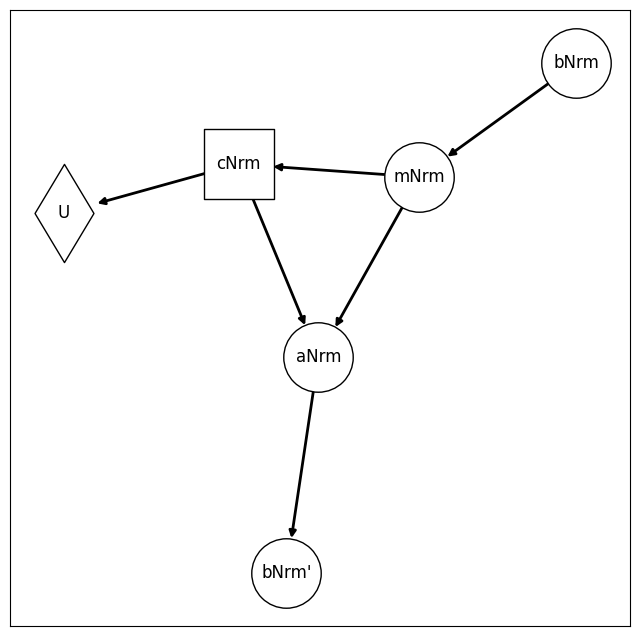

In [4]:
draw_frame_model(frame_model_A)

In [5]:
isinstance(
    list(frame_model_A.frames.var("bNrm").parents.values())[0], BackwardFrameReference
)

True

In [6]:
frame_model_A.frames.var("aNrm").children

{('bNrm',): <FFR:('bNrm',)>}

In [7]:
frame_model_A.infinite

True

## Modifying the model

-- To refactor to use standalone models

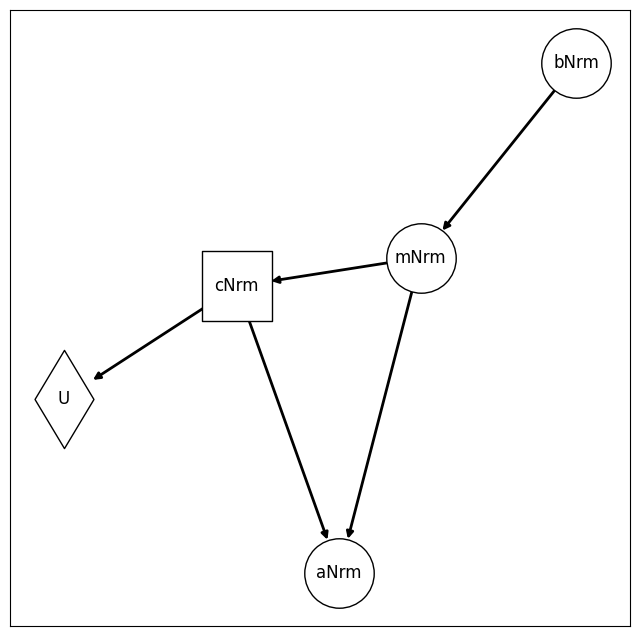

In [8]:
draw_frame_model(frame_model_A.make_terminal())

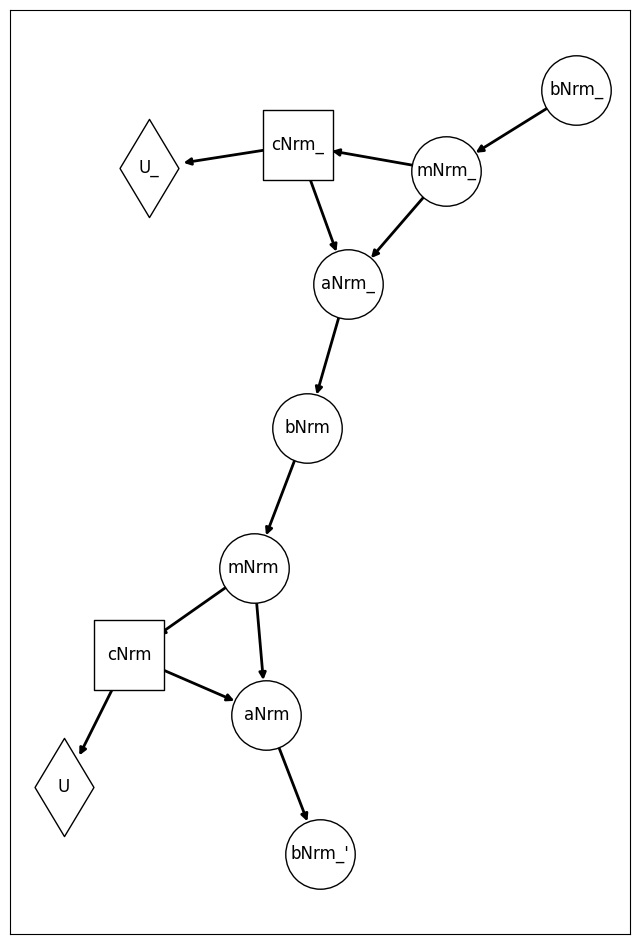

In [9]:
double_model = frame_model_A.prepend(frame_model_A)
draw_frame_model(double_model, figsize=(8, 12))

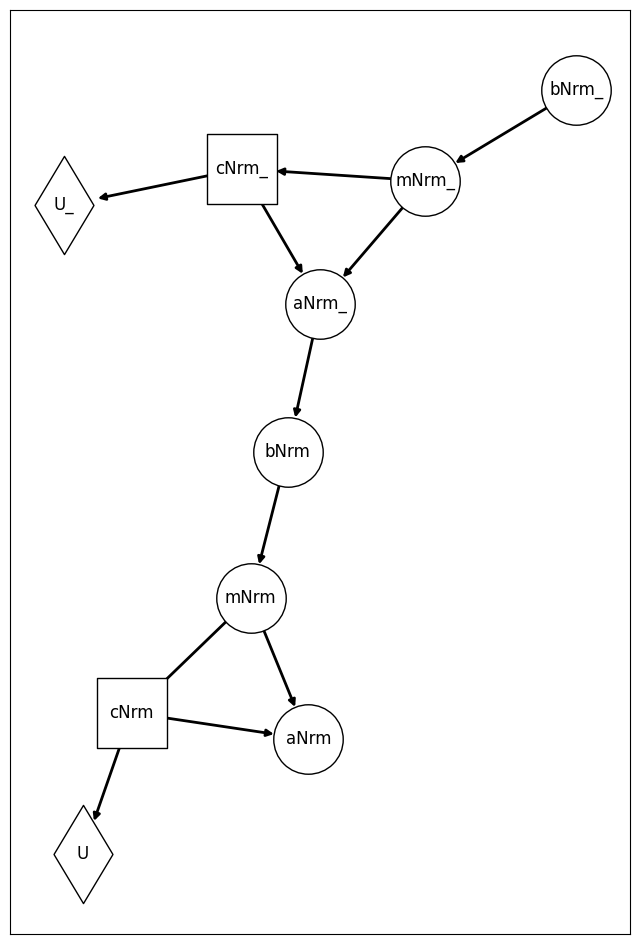

In [10]:
double_model = frame_model_A.make_terminal().prepend(frame_model_A)
draw_frame_model(double_model, figsize=(8, 12))

## repeat()

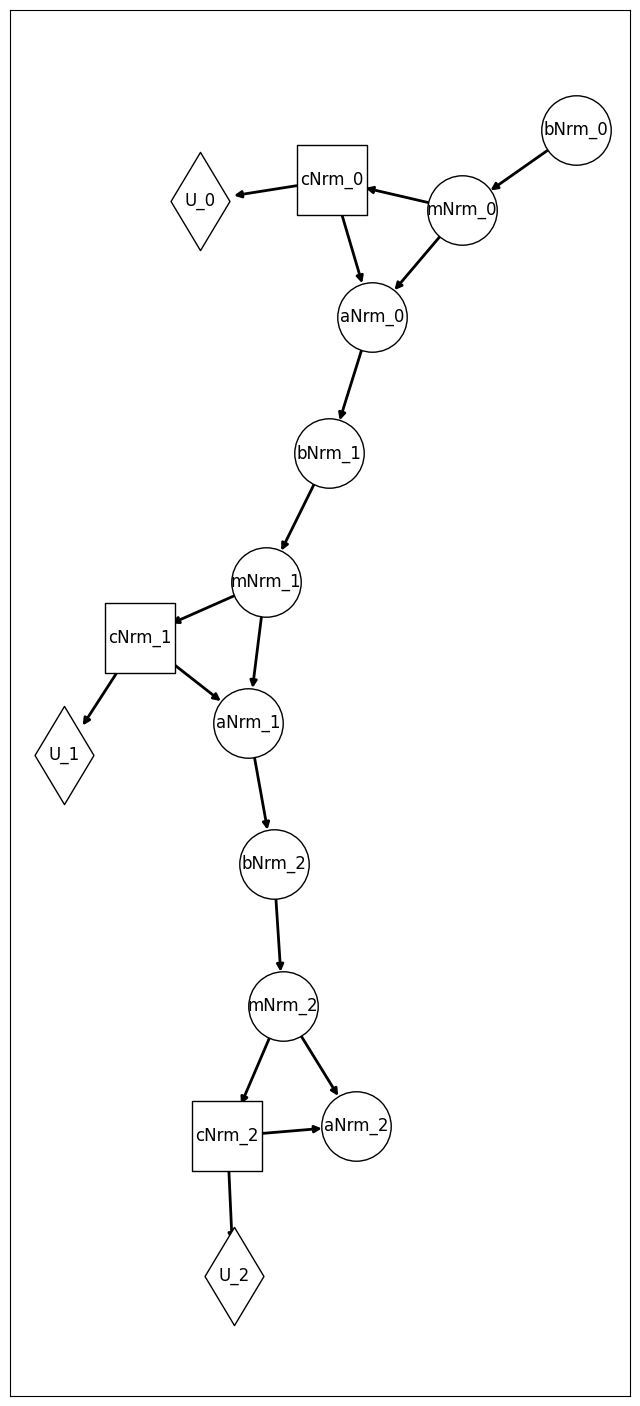

In [11]:
repeat_model = frame_model_A.repeat({"bNrm": {"Rfree": [1.01, 1.03, 1.02]}})
draw_frame_model(repeat_model, figsize=(8, 18))

In [12]:
repeat_model.frames.var("bNrm_1").context["Rfree"]

1.03

In [13]:
repeat_model.frames.var("aNrm_2").children

{}

## Trying again at a solver ....

- [ ] Create grid of state values with a 'forward simulation' with dummy strategies
- [ ] For each control variable, backwards:
   - [ ] Create objective function $f$ summing:
      - [ ] Direct rewards of (a, s)
      - [ ] Weighted expected value of (a,s)
  - [ ] Over a grid of state values in the control variable's scope:
     - [ ] Find optimal a* for s given $f$
  - [ ] Using (s, a*) pairs:
     - [ ] Interpolate
     - [ ] Into a decision rule
- [ ] When all the decision rules are done, forward simulate.


In [14]:
model = frame_model_A

In [15]:
model.frames

FrameSet([(('bNrm',),
           <<class 'HARK.frame.Frame'>, target:('bNrm',), scope:('aNrm',)>),
          (('mNrm',),
           <<class 'HARK.frame.Frame'>, target:('mNrm',), scope:('bNrm', 'TranShk')>),
          (('cNrm',),
           <<class 'HARK.frame.Frame'>, target:('cNrm',), scope:('mNrm',)>),
          (('U',),
           <<class 'HARK.frame.Frame'>, target:('U',), scope:('cNrm', 'CRRA')>),
          (('aNrm',),
           <<class 'HARK.frame.Frame'>, target:('aNrm',), scope:('mNrm', 'cNrm')>)])

In [16]:
def make_decision_rule(control_frame: Frame):
    # get scope
    scope = control_frame.scope

    # get objective function

    # get grid over the scope

    # get optimal action for each scope point given objective

    # interpolate from (s, a*) into decision rule

    pass

In [17]:
def create_value_function_from_reward_transition(transition, local_context):
    def value_function(**parent_state):
        inputs = parent_state.copy()
        inputs.update(local_context)

        return transition(**inputs)

    return value_function

In [18]:
for f in range(len(model.frames) - 1, 0, -1):
    frame = model.frames.iloc(f)

    if frame.reward:
        frame.value = create_value_function_from_reward_transition(
            frame.transition, frame.context
        )

    elif frame.control:
        pass

    elif len(frame.children) == 0:
        # terminal chance node

        pass

    else:
        # intermediate state node
        pass

In [19]:
model.frames.iloc(3).context

{'CRRA': 2.0}

In [20]:
model.frames.iloc(3).value(**{"cNrm": 2})

(-0.5,)

### pycid rules in parallel...

In [21]:
'''
def impute_random_decision(self, d: str) -> None:
        """Impute a random policy to the given decision node"""
        try:
            domain = self.model.domain[d]
        except KeyError:
            raise ValueError(f"can't figure out domain for {d}, did you forget to specify DecisionDomain?")
        else:
            self.model[d] = StochasticFunctionCPD(
                d, lambda **pv: {outcome: 1 / len(domain) for outcome in domain}, self, domain, label="random_decision"
            )
'''

'\ndef impute_random_decision(self, d: str) -> None:\n        """Impute a random policy to the given decision node"""\n        try:\n            domain = self.model.domain[d]\n        except KeyError:\n            raise ValueError(f"can\'t figure out domain for {d}, did you forget to specify DecisionDomain?")\n        else:\n            self.model[d] = StochasticFunctionCPD(\n                d, lambda **pv: {outcome: 1 / len(domain) for outcome in domain}, self, domain, label="random_decision"\n            )\n'

In [22]:
'''
def expected_utility(
        self, context: Dict[str, Outcome], intervention: Dict[str, Outcome] = None, agent: AgentLabel = 0
    ) -> float:
        """Compute the expected utility of an agent for a given context and optional intervention
        For example:
        cid = get_minimal_cid()
        out = self.expected_utility({'D':1}) #TODO: give example that uses context
        Parameters
        ----------
        context: Node values to condition upon. A dictionary mapping of node => value.
        intervention: Interventions to apply. A dictionary mapping node => value.
        agent: Evaluate the utility of this agent.
        """
        return sum(self.expected_value(self.agent_utilities[agent], context, intervention=intervention))
'''

'\ndef expected_utility(\n        self, context: Dict[str, Outcome], intervention: Dict[str, Outcome] = None, agent: AgentLabel = 0\n    ) -> float:\n        """Compute the expected utility of an agent for a given context and optional intervention\n        For example:\n        cid = get_minimal_cid()\n        out = self.expected_utility({\'D\':1}) #TODO: give example that uses context\n        Parameters\n        ----------\n        context: Node values to condition upon. A dictionary mapping of node => value.\n        intervention: Interventions to apply. A dictionary mapping node => value.\n        agent: Evaluate the utility of this agent.\n        """\n        return sum(self.expected_value(self.agent_utilities[agent], context, intervention=intervention))\n'

In [23]:
'''
def impute_optimal_decision(self, decision: str) -> None:
        """Impute an optimal policy to the given decision node"""
        # self.add_cpds(random.choice(self.optimal_pure_decision_rules(d)))
        self.impute_random_decision(decision)
        domain = self.model.domain[decision]
        utility_nodes = self.agent_utilities[self.decision_agent[decision]]
        descendant_utility_nodes = list(set(utility_nodes).intersection(nx.descendants(self, decision)))
        copy = self.copy()  # using a copy "freezes" the policy so it doesn't adapt to future interventions

        @lru_cache(maxsize=1000)
        def opt_policy(**parent_values: Outcome) -> Outcome:
            eu = {}
            for d in domain:
                parent_values[decision] = d
                eu[d] = sum(copy.expected_value(descendant_utility_nodes, parent_values))
            return max(eu, key=eu.get)  # type: ignore

        self.add_cpds(StochasticFunctionCPD(decision, opt_policy, self, domain=domain, label="opt"))
'''

'\ndef impute_optimal_decision(self, decision: str) -> None:\n        """Impute an optimal policy to the given decision node"""\n        # self.add_cpds(random.choice(self.optimal_pure_decision_rules(d)))\n        self.impute_random_decision(decision)\n        domain = self.model.domain[decision]\n        utility_nodes = self.agent_utilities[self.decision_agent[decision]]\n        descendant_utility_nodes = list(set(utility_nodes).intersection(nx.descendants(self, decision)))\n        copy = self.copy()  # using a copy "freezes" the policy so it doesn\'t adapt to future interventions\n\n        @lru_cache(maxsize=1000)\n        def opt_policy(**parent_values: Outcome) -> Outcome:\n            eu = {}\n            for d in domain:\n                parent_values[decision] = d\n                eu[d] = sum(copy.expected_value(descendant_utility_nodes, parent_values))\n            return max(eu, key=eu.get)  # type: ignore\n\n        self.add_cpds(StochasticFunctionCPD(decision, opt_policy,

## Forward simulating the model

In [24]:
frame_agent_A = FrameAgentType(
    frame_model_A, T_sim=5000, AgentCount=200, read_shocks=True, cycles=0
)

# frame_agent_A.solve()
# frame_agent_A.track_vars += [
#    "mNrm",
#    "cNrm",
#    "aNrm",
#    "bNrm",
#    'U'
# ]

# Doesn't work yet.
# frame_agent_A.initialize_sim()
# frame_agent_A.simulate()

In [25]:
## TODO: Forward simulate

## Progressively more complex models

In [26]:
# maybe replace reference to init_portfolio to self.parameters?
frame_model_B = FrameModel(
    [
        # todo : make an aggegrate value
        Frame(
            ("PermShk"),
            None,
            default={
                "PermShk": 1.0
            },  # maybe this is unnecessary because the shock gets sampled at t = 0
            # this is discretized before it's sampled
            transition=IndexDistribution(
                Lognormal.from_mean_std,
                {
                    "mean": init_parameters["PermGroFac"],
                    "std": init_parameters["PermShkStd"],
                },
            ).discretize(
                init_parameters["PermShkCount"], method="equiprobable", tail_N=0
            ),
        ),
        Frame(
            ("TranShk"),
            None,
            default={
                "TranShk": 1.0
            },  # maybe this is unnecessary because the shock gets sampled at t = 0
            transition=IndexDistribution(
                MeanOneLogNormal, {"sigma": init_parameters["TranShkStd"]}
            ).discretize(
                init_parameters["TranShkCount"], method="equiprobable", tail_N=0
            ),
        ),
        Frame(
            ("Rport"),
            ("Share", "Risky", "Rfree"),
            transition=lambda Share, Risky, Rfree: (
                Share * Risky + (1.0 - Share) * Rfree,
            ),
        ),
        Frame(
            ("bNrm",),
            ("aNrm", "Rport", "PermShk"),
            transition=lambda aNrm, Rport, PermShk: (Rport / PermShk) * aNrm,
        ),
        Frame(
            ("mNrm",),
            ("bNrm", "TranShk"),
            transition=lambda bNrm, TranShk: (bNrm + TranShk,),
        ),
        Frame(("cNrm"), ("Adjust", "mNrm", "Share"), control=True),
        Frame(
            ("U"),
            (
                "cNrm",
                "CRRA",
            ),  ## Note CRRA here is a parameter not a state var            transition = lambda self, cNrm, CRRA : (CRRAutility(cNrm, CRRA),),
            reward=True,
        ),
        Frame(
            ("aNrm"),
            ("mNrm", "cNrm"),
            default={"aNrm": birth_aNrmNow},
            transition=lambda mNrm, cNrm: (mNrm - cNrm,),
        ),
    ],
    init_parameters,
)

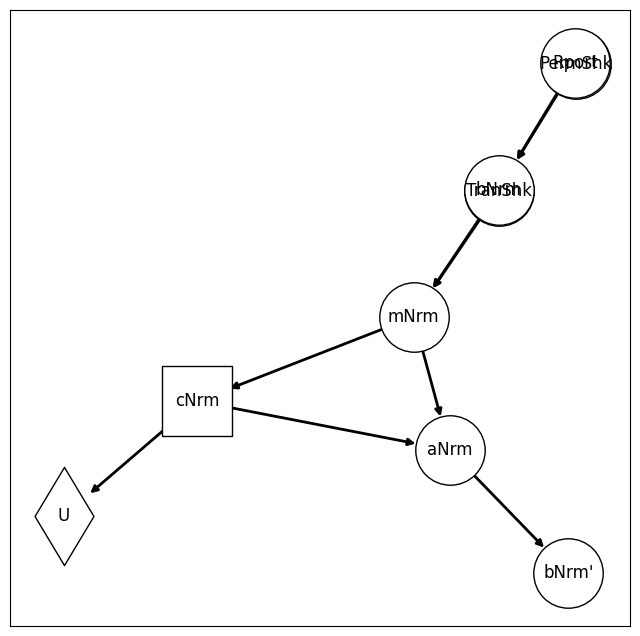

In [27]:
draw_frame_model(frame_model_B)  # , dot = True)

In [28]:
# TODO: streamline this so it can draw the parameters from context
def birth_aNrmNow(self, N):
    """
    Birth value for aNrmNow
    """
    return Lognormal(
        mu=self.aNrmInitMean,
        sigma=self.aNrmInitStd,
        seed=self.RNG.integers(0, 2**31 - 1),
    ).draw(N)

    # maybe replace reference to init_portfolio to self.parameters?


frame_model_C = FrameModel(
    [
        # todo : make an aggegrate value
        Frame(
            ("PermShk"),
            None,
            default={
                "PermShk": 1.0
            },  # maybe this is unnecessary because the shock gets sampled at t = 0
            # this is discretized before it's sampled
            transition=IndexDistribution(
                Lognormal.from_mean_std,
                {
                    "mean": init_parameters["PermGroFac"],
                    "std": init_parameters["PermShkStd"],
                },
            ).discretize(
                init_parameters["PermShkCount"], method="equiprobable", tail_N=0
            ),
        ),
        Frame(
            ("TranShk"),
            None,
            default={
                "TranShk": 1.0
            },  # maybe this is unnecessary because the shock gets sampled at t = 0
            transition=IndexDistribution(
                MeanOneLogNormal, {"sigma": init_parameters["TranShkStd"]}
            ).discretize(
                init_parameters["TranShkCount"], method="equiprobable", tail_N=0
            ),
        ),
        Frame(  ## TODO: Handle Risky as an Aggregate value
            ("Risky"),
            None,
            transition=IndexDistribution(
                Lognormal.from_mean_std,
                {
                    "mean": init_parameters["RiskyAvg"],
                    "std": init_parameters["RiskyStd"],
                }
                # seed=self.RNG.integers(0, 2 ** 31 - 1) : TODO: Seed logic
            ).discretize(init_parameters["RiskyCount"], method="equiprobable"),
            aggregate=True,
        ),
        Frame(
            ("Rport"),
            ("Share", "Risky", "Rfree"),
            transition=lambda Share, Risky, Rfree: (
                Share * Risky + (1.0 - Share) * Rfree,
            ),
        ),
        Frame(
            ("bNrm",),
            ("aNrm", "Rport", "PermShk"),
            transition=lambda aNrm, Rport, PermShk: (Rport / PermShk) * aNrm,
        ),
        Frame(
            ("mNrm",),
            ("bNrm", "TranShk"),
            transition=lambda bNrm, TranShk: (bNrm + TranShk,),
        ),
        Frame(("Share"), ("Adjust", "mNrm"), default={"Share": 0}, control=True),
        Frame(("cNrm"), ("Adjust", "mNrm", "Share"), control=True),
        Frame(
            ("U"),
            ("cNrm", "CRRA"),  ## Note CRRA here is a parameter not a state var
            transition=lambda cNrm, CRRA: (CRRAutility(cNrm, CRRA),),
            reward=True,
        ),
        Frame(
            ("aNrm"),
            ("mNrm", "cNrm"),
            default={"aNrm": birth_aNrmNow},
            transition=lambda mNrm, cNrm: (mNrm - cNrm,),
        ),
    ],
    init_parameters,
)

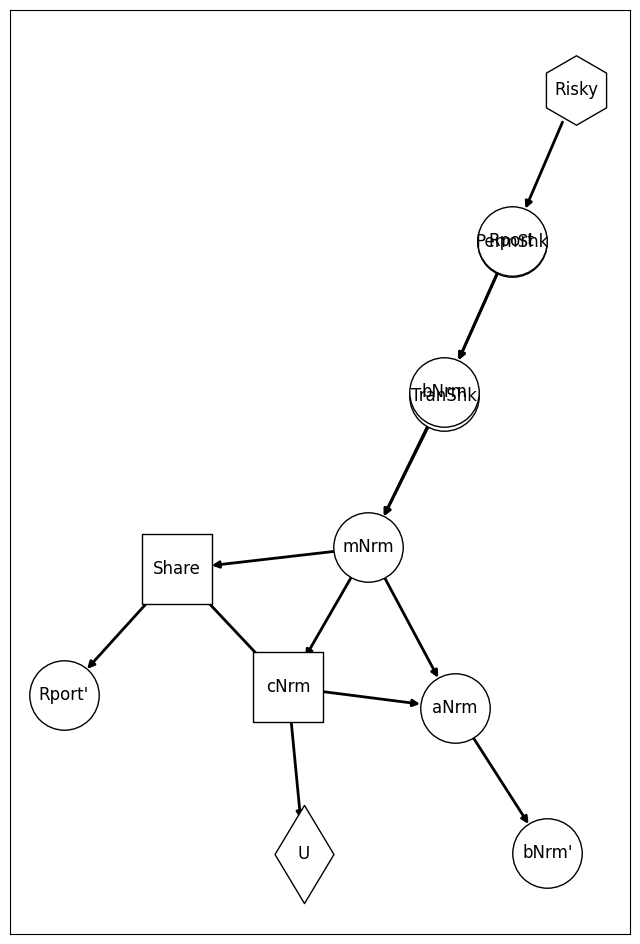

In [29]:
draw_frame_model(frame_model_C, figsize=(8, 12))  # , dot = True)